Functions for detecting change points in the cross section profiles.
Two approaches: piecewise linear regression, detect peaks in smoothed curvature. 
In this case, curvature is the second derivative of the elevation profile, and not curvature from the elevation map directly. 

Then need to figure out the elevation of the valley bottom from these results.


Useful resources:
- https://gurobi-optimization-gurobi-optimods.readthedocs-hosted.com/en/latest/mods/lad-regression.html
- https://pro.arcgis.com/en/pro-app/latest/tool-reference/space-time-pattern-mining/how-change-point-detection-works.htm#:~:text=Slope%20(Linear%20trend)%E2%80%94Detects,having%20the%20same%20standard%20deviation.
- https://stackoverflow.com/questions/47519626/using-numpy-scipy-to-identify-slope-changes-in-digital-signals
- https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.find_peaks_cwt.html
- https://docs.scipy.org/doc/scipy/reference/signal.html
- https://github.com/deepcharles/ruptures


functions to implement:
- slope threshold
- linear regression (ols, lad) two piece
- piece wise analysis
- curvature analysis peak
- curvature analysis waveforem
- change point detection

Might need to find where cross section intersects channel (min) and reset alphas

In [220]:
import pandas as pd
import shapely
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal

In [342]:
def get_subset(points, csid):
    cs = points.loc[points['cross_section'] == csid]
    return {'left': cs.loc[cs['alpha'] <= 0], 'right': cs.loc[cs['alpha'] >= 0]}

def reset_alphas():
    pass
    
def get_spline(half_profile):
    y_spl = UnivariateSpline(half_profile['alpha'], half_profile['elevation'], s=0, k=3)
    y_spl_1d = y_spl.derivative(n=1)
    y_spl_2d = y_spl.derivative(n=2)
    return {'spline': y_spl(half_profile['alpha']), 'slope': y_spl_1d(half_profile['alpha']),
            'curvature': y_spl_2d(half_profile['alpha'])}

def get_peaks():
    pass

In [262]:
# load example signals (elevation and slope profiles)
points  = pd.read_csv("../toy_data/11_cross_sections.csv", index_col=0)
points = points.loc[np.isfinite(points['elevation'])]
points= points.drop_duplicates()
points.head()

,alpha,elevation,slope,point,cross_section
0,-200,119.146116,8.283040,POINT (-198329.07052593044 -102992.18899796973),0
1,-195,118.278486,9.608321,POINT (-198327.2404359487 -102987.53595910691),0
2,-190,118.203581,9.155859,POINT (-198325.410345967 -102982.88292024411),0
3,-185,117.514051,13.163662,POINT (-198323.5802559853 -102978.2298813813),0
4,-180,117.013105,NaN,POINT (-198321.75016600356 -102973.57684251848),0


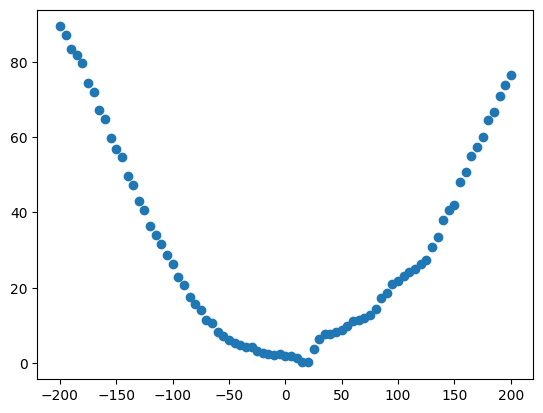

In [332]:
csid = 17
plt.scatter(points.loc[points['cross_section'] == csid]['alpha'], 
            points.loc[points['cross_section'] == csid]['elevation'])

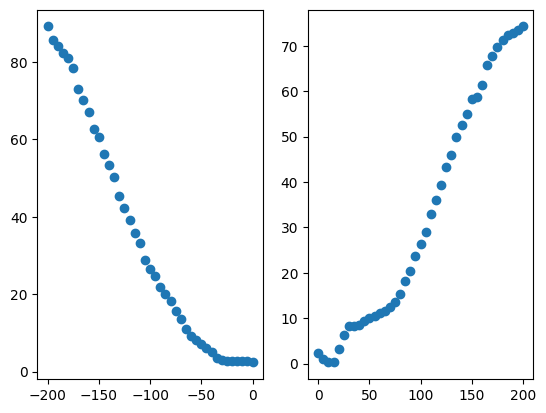

In [333]:
cs = get_subset(points, 14)

fig, axes = plt.subplots(1, 2)
axes[0].scatter(cs['left']['alpha'], cs['left']['elevation'])
axes[1].scatter(cs['right']['alpha'], cs['right']['elevation'])

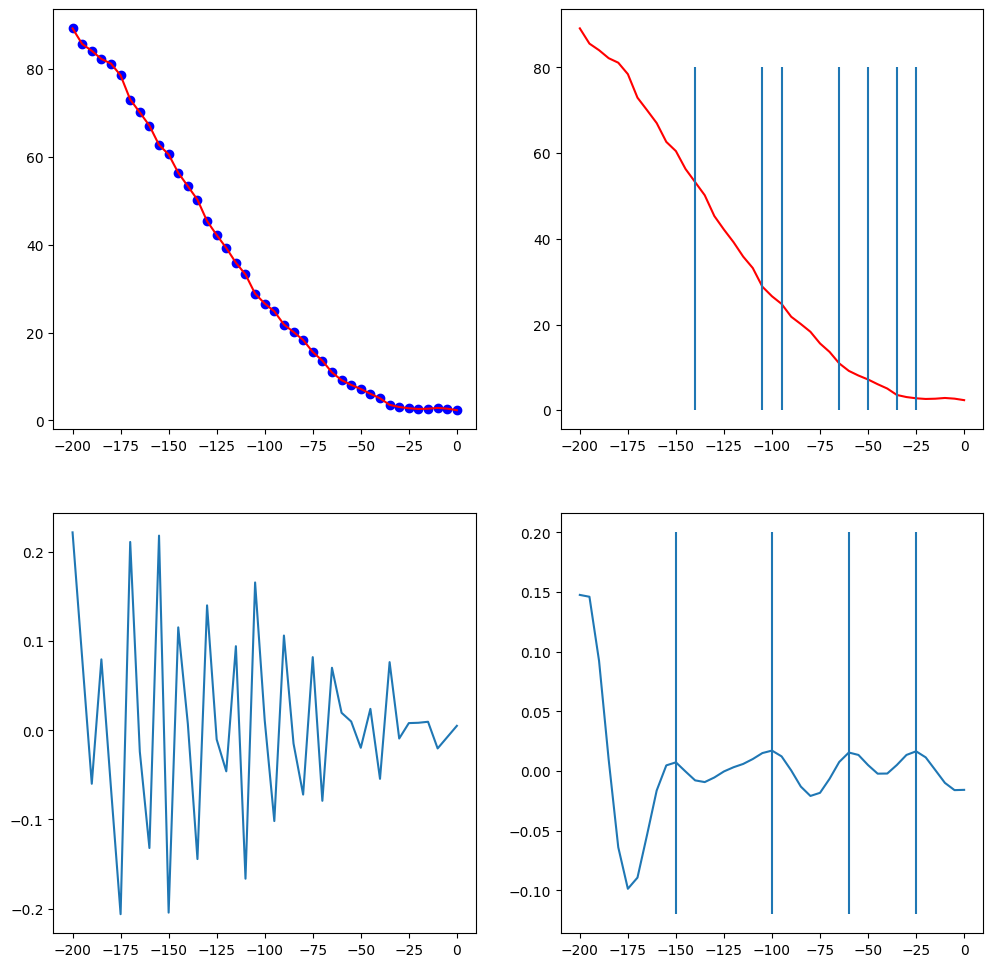

In [348]:
spline = get_spline(cs['left'])
peaks = signal.find_peaks_cwt(spline['curvature'], widths=np.arange(3,10), wavelet=signal.ricker)
transform = signal.cwt(spline['curvature'], widths=[3], wavelet=signal.ricker)
peaks2 = signal.find_peaks(transform[0])[0]

fig, axes = plt.subplots(2,2, figsize=(12,12))

axes[0,0].plot(cs['left']['alpha'], cs['left']['elevation'], 'bo')
axes[0,0].plot(cs['left']['alpha'], spline['spline'], 'r')
axes[0,1].plot(cs['left']['alpha'], spline['spline'], 'r')
axes[0,1].vlines(cs['left']['alpha'][peaks], 0, 80)

axes[1,0].plot(cs['left']['alpha'], spline['curvature'])
axes[1,1].plot(cs['left']['alpha'], transform[0])
axes[1,1].vlines(cs['left']['alpha'][peaks2], -.12, 0.2)

In [ ]:
# get value accross all hillslopes, both sides, quantize, filter